In [1]:
!pip install lpips

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.5 MB/s eta 0:00:00


In [2]:
import os
import cv2
import numpy as np
import math
from skimage.registration import optical_flow_ilk
from google.colab.patches import cv2_imshow
import shutil
import lpips
import torch
from torchvision.transforms import ToTensor

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
def get_warped_image(after_img, optical_flow):
    flow_x = optical_flow[0]
    flow_y = optical_flow[1]
    warped_image = np.ones_like(after_img)

    for i in range(after_img.shape[0]):
        for j in range(after_img.shape[1]):
            x = i + flow_x[i][j]
            y = j + flow_y[i][j]

            x1 = math.floor(x)
            if x1 < 0:
                x1 = 0
            y1 = math.floor(y)
            if y1 < 0:
                y1 = 0
            x2 = math.ceil(x)
            if x2 >= after_img.shape[0]:
                x2 = after_img.shape[0] - 1
            y2 = math.ceil(y)
            if y2 >= after_img.shape[1]:
                y2 = after_img.shape[1] - 1

            if x1 >= after_img.shape[0]:
                x = after_img.shape[0] - 1
                x1 = x
                x2 = x
            if y1 >= after_img.shape[1]:
                y = after_img.shape[0] - 1
                y1 = y
                y2 = y
            if x2 < 0:
                x = 0
                x1 = 0
                x2 = 0
            if y2 < 0:
                y = 0
                y1 = 0
                y2 = 0

            if y1 == y2 and x1 == x2:
                warped_image[i][j] = after_img[x1][y1]
            elif y1 == y2 and x1 != x2:
                y = y1
                warped_image[i][j] = after_img[x1][y] * (x2 - x) + after_img[x2][y] * (x - x1)
            elif x1 == x2 and y1 != y2:
                x = x1
                warped_image[i][j] = after_img[x][y1] * (y2 - y) + after_img[x][y2] * (y - y1)
            else:
                warped_image[i][j] = after_img[x1][y1] * (x2 - x) * (y2 - y) + after_img[x2][y1] * (x - x1) * (y2 - y) + after_img[x1][y2] * (x2 - x) * (y - y1) + after_img[x2][y2] * (x - x1) * (y - y1)

    return warped_image


In [7]:
def get_multiscale_OF_forward(beforeImg, afterImg, downscale = 0):
  last_OF = np.zeros((2,afterImg.shape[0]//2**(downscale+1),afterImg.shape[1]//2**(downscale+1)))
  warped_img = np.empty((0,))
  for i in range(downscale,-1,-1):
    k = 2**i
    new_width = beforeImg.shape[1] // k
    new_height = beforeImg.shape[0] // k
    down_scaled_beforeImg = cv2.resize(beforeImg, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    down_scaled_afterImg = cv2.resize(afterImg, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    last_OF = last_OF*2
    upscaled_last_OF = np.empty((2, new_height, new_width))
    for i in range(last_OF.shape[0]):
      upscaled_last_OF[i] = cv2.resize(last_OF[i],None, fx=2,fy=2, interpolation=cv2.INTER_LINEAR)

    warped_img = get_warped_image(down_scaled_afterImg,upscaled_last_OF)

    OF = optical_flow_ilk(down_scaled_beforeImg, warped_img)

    last_OF = upscaled_last_OF + OF

  return last_OF

In [8]:
def get_multiscale_OF_backward(beforeImg, afterImg, downscale = 0):
  last_OF = np.zeros((2,afterImg.shape[0]//2**(downscale+1),afterImg.shape[1]//2**(downscale+1)))
  warped_img = np.empty((0,))
  for i in range(downscale,-1,-1):
    k = 2**i
    new_width = beforeImg.shape[1] // k
    new_height = beforeImg.shape[0] // k
    down_scaled_beforeImg = cv2.resize(beforeImg, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    down_scaled_afterImg = cv2.resize(afterImg, (new_width, new_height), interpolation=cv2.INTER_LINEAR)
    last_OF = last_OF*2
    upscaled_last_OF = np.empty((2, new_height, new_width))
    for i in range(last_OF.shape[0]):
      upscaled_last_OF[i] = cv2.resize(last_OF[i],None, fx=2,fy=2, interpolation=cv2.INTER_LINEAR)
    # note the change as compared to forward flow
    warped_img = get_warped_image(down_scaled_beforeImg,upscaled_last_OF)

    OF = optical_flow_ilk(down_scaled_afterImg,warped_img)

    last_OF = upscaled_last_OF + OF

  return last_OF

In [9]:
def get_warped_image2(after_img, optical_flow,warped_image):
    flow_x = optical_flow[0]
    flow_y = optical_flow[1]

    for i in range(after_img.shape[0]):
        for j in range(after_img.shape[1]):
            if(warped_image[i][j][0]==0):
              warped_image[i][j] = after_img[i][j]
              continue
            x = i + flow_x[i][j]
            y = j + flow_y[i][j]

            x1 = math.floor(x)
            if x1 < 0:
                x1 = 0
            y1 = math.floor(y)
            if y1 < 0:
                y1 = 0
            x2 = math.ceil(x)
            if x2 >= after_img.shape[0]:
                x2 = after_img.shape[0] - 1
            y2 = math.ceil(y)
            if y2 >= after_img.shape[1]:
                y2 = after_img.shape[1] - 1

            if x1 >= after_img.shape[0]:
                x = after_img.shape[0] - 1
                x1 = x
                x2 = x
            if y1 >= after_img.shape[1]:
                y = after_img.shape[0] - 1
                y1 = y
                y2 = y
            if x2 < 0:
                x = 0
                x1 = 0
                x2 = 0
            if y2 < 0:
                y = 0
                y1 = 0
                y2 = 0

            if y1 == y2 and x1 == x2:
                warped_image[i][j] = after_img[x1][y1]
            elif y1 == y2 and x1 != x2:
                y = y1
                warped_image[i][j] = after_img[x1][y] * (x2 - x) + after_img[x2][y] * (x - x1)
            elif x1 == x2 and y1 != y2:
                x = x1
                warped_image[i][j] = after_img[x][y1] * (y2 - y) + after_img[x][y2] * (y - y1)
            else:
                warped_image[i][j] = after_img[x1][y1] * (x2 - x) * (y2 - y) + after_img[x2][y1] * (x - x1) * (y2 - y) + after_img[x1][y2] * (x2 - x) * (y - y1) + after_img[x2][y2] * (x - x1) * (y - y1)

    return warped_image


In [10]:
def get_interpolated_frames(beforeImg,afterImg,K,downscale):
  gray_beforeImg = cv2.cvtColor(beforeImg, cv2.COLOR_BGR2GRAY)
  gray_afterImg = cv2.cvtColor(afterImg, cv2.COLOR_BGR2GRAY)
  # foward interpolated image
  original_OF_forward = get_multiscale_OF_forward(gray_beforeImg,gray_afterImg,downscale)
  Forward_interpolated_images = []
  for k in range(1,K):
    temporary_OF1 = original_OF_forward*(k/K)
    temporary_OF2 = original_OF_forward*(1-k/K)
    warped_image = np.zeros_like(afterImg)
    for i in range(beforeImg.shape[0]):
      for j in range(beforeImg.shape[1]):
        newi = round(i + temporary_OF1[0][i][j])
        newj = round(j + temporary_OF1[1][i][j])
        if(newi<0):
          newi = 0
        if(newi>=beforeImg.shape[0]):
          newi = beforeImg.shape[0]-1
        if(newj<0):
          newj = 0
        if(newj>=beforeImg.shape[1]):
          newj = beforeImg.shape[1]-1

        warped_image[newi][newj] = np.array([1,1,1]) # 1 is just for symbol
    warped_image = get_warped_image2(afterImg,temporary_OF2,warped_image)
    Forward_interpolated_images.append(warped_image)

  Backward_interpolated_images = []
  original_OF_backward = get_multiscale_OF_backward(gray_afterImg,gray_beforeImg,downscale)
  for k in range(1,K):
    temporary_OF1 = original_OF_backward*(1-k/K)
    temporary_OF2 = original_OF_backward*(k/K)
    warped_image = np.zeros_like(afterImg)
    for i in range(afterImg.shape[0]):
      for j in range(afterImg.shape[1]):
        newi = round(i + temporary_OF1[0][i][j])
        newj = round(j + temporary_OF1[1][i][j])
        if(newi<0):
          newi = 0
        if(newi>=afterImg.shape[0]):
          newi = afterImg.shape[0]-1
        if(newj<0):
          newj = 0
        if(newj>=afterImg.shape[1]):
          newj = afterImg.shape[1]-1

        warped_image[newi][newj] = np.array([1,1,1]) # 1 is just for symbol
    warped_image = get_warped_image2(beforeImg,temporary_OF2,warped_image)
    Backward_interpolated_images.append(warped_image)

  # Weighted average of forward and backward optical flow
  Interpolated_images = []
  for k in range(1,K):
    interpolated_image = (k/K)*Forward_interpolated_images[k-1]+(1-k/K)*Backward_interpolated_images[k-1]
    Interpolated_images.append(interpolated_image)
  return Interpolated_images

In [11]:
def save_interpolated_frames(rgb_images_path_list,output_path,K,downscale):
  s = "K:" + str(K) + "_downscale:" + str(downscale)
  new_folder = os.path.join(output_path, s)
  if not os.path.exists(new_folder):
    os.makedirs(new_folder)
  for i in range(0, len(rgb_images_path_list) - K, K):
    beforeImg = cv2.imread(rgb_images_path_list[i])
    afterImg = cv2.imread(rgb_images_path_list[i+K])
    # saving beforeImg and afterImg
    beforeImg_path = os.path.join(new_folder,f"{'%04d' % i}.png")
    cv2.imwrite(beforeImg_path, beforeImg)
    afterImg_path = os.path.join(new_folder,f"{'%04d' % (i+K)}.png")
    cv2.imwrite(afterImg_path, afterImg)
    Interpolated_images = get_interpolated_frames(beforeImg,afterImg,K,downscale)
    for k in range(1,K):
      file_name = f"{(i+k):04d}.png"
      file_path = os.path.join(new_folder, file_name)
      cv2.imwrite(file_path, Interpolated_images[k-1])

In [12]:
def calculate_metrics(image1, image2, lpips_model):
  img1 = cv2.imread(image1)
  img2 = cv2.imread(image2)

  # Convert images to tensors
  img1_tensor = ToTensor()(img1).unsqueeze(0)
  img2_tensor = ToTensor()(img2).unsqueeze(0)

  # Calculate PSNR
  psnr = cv2.PSNR(img1, img2)

  # Calculate LPIPS score

  lpips_score = lpips_model(img1_tensor, img2_tensor).item()

  return psnr, lpips_score

In [ ]:
downscale = 1
source_folder1 = '/content/drive/MyDrive/DVPA_A1/00001/rgb'
rgb_images_path_list = sorted([os.path.join(source_folder1, f) for f in os.listdir(source_folder1) if f.endswith('.png')])
output_path1 = '/content/drive/MyDrive/DVPA_A1/00001'
# K = 2
save_interpolated_frames(rgb_images_path_list,output_path1,2,downscale)
# K = 3
save_interpolated_frames(rgb_images_path_list,output_path1,3,downscale)
# K = 4
save_interpolated_frames(rgb_images_path_list,output_path1,4,downscale)

In [ ]:
downscale = 1
psnr_scores1 = {}
lpips_scores1 = {}
lpips_model = lpips.LPIPS(net='alex')
for K in range(2, 5):  # Adjust the range as needed
  i = 0
  s = "K:" + str(K) + "_downscale:" + str(downscale)
  folder1 = '/content/drive/MyDrive/DVPA_A1/00001/rgb'
  folder2 = os.path.join('/content/drive/MyDrive/DVPA_A1/00001',s)
  for root, _, files in os.walk(folder1):
    for filename in files:
      i = i+1
      if(i%K == 0):
        continue
      # Check if the corresponding image exists in folder2
      image_path1 = os.path.join(root, filename)
      image_path2 = os.path.join(folder2, filename)  # Adjust the file extension as needed
      if os.path.exists(image_path2):
        psnr, lpips_score = calculate_metrics(image_path1, image_path2,lpips_model)
        if K not in psnr_scores1:
          psnr_scores1[K] = []
          lpips_scores1[K] = []

        psnr_scores1[K].append(psnr)
        lpips_scores1[K].append(lpips_score)

# Compute average PSNR and LPIPS scores for each scale and K
for K, psnr_list in psnr_scores1.items():
  avg_psnr = np.mean(psnr_list)
  avg_lpips = np.mean(lpips_scores1[K])
  print(f'For K={K}, with number of scales={downscale}, Average PSNR: {avg_psnr:.2f}, Average LPIPS: {avg_lpips:.4f}')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
For K=2, with number of scales=1, Average PSNR: 203.29, Average LPIPS: 0.0474
For K=3, with number of scales=1, Average PSNR: 161.15, Average LPIPS: 0.0704
For K=4, with number of scales=1, Average PSNR: 101.67, Average LPIPS: 0.1045


In [ ]:
downscale = 3
source_folder1 = '/content/drive/MyDrive/DVPA_A1/00001/rgb'
rgb_images_path_list = sorted([os.path.join(source_folder1, f) for f in os.listdir(source_folder1) if f.endswith('.png')])
output_path1 = '/content/drive/MyDrive/DVPA_A1/00001'
# K = 2
save_interpolated_frames(rgb_images_path_list,output_path1,2,downscale)
# K = 3
save_interpolated_frames(rgb_images_path_list,output_path1,3,downscale)
# K = 4
save_interpolated_frames(rgb_images_path_list,output_path1,4,downscale)

In [ ]:
downscale = 3
psnr_scores2 = {}
lpips_scores2 = {}
lpips_model = lpips.LPIPS(net='alex')
for K in range(2, 5):  # Adjust the range as needed
  i = 0
  s = "K:" + str(K) + "_downscale:" + str(downscale)
  folder1 = '/content/drive/MyDrive/DVPA_A1/00001/rgb'
  folder2 = os.path.join('/content/drive/MyDrive/DVPA_A1/00001',s)
  for root, _, files in os.walk(folder1):
    for filename in files:
      i = i+1
      if(i%K == 0):
        continue
      # Check if the corresponding image exists in folder2
      image_path1 = os.path.join(root, filename)
      image_path2 = os.path.join(folder2, filename)  # Adjust the file extension as needed
      if os.path.exists(image_path2):
        psnr, lpips_score = calculate_metrics(image_path1, image_path2,lpips_model)
        if K not in psnr_scores2:
          psnr_scores2[K] = []
          lpips_scores2[K] = []

        psnr_scores2[K].append(psnr)
        lpips_scores2[K].append(lpips_score)

# Compute average PSNR and LPIPS scores for each scale and K
for K, psnr_list in psnr_scores2.items():
  avg_psnr = np.mean(psnr_list)
  avg_lpips = np.mean(lpips_scores2[K])
  print(f'For K={K}, with number of scales={downscale}, Average PSNR: {avg_psnr:.2f}, Average LPIPS: {avg_lpips:.4f}')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
For K=2, with number of scales=3, Average PSNR: 203.32, Average LPIPS: 0.0478
For K=3, with number of scales=3, Average PSNR: 161.15, Average LPIPS: 0.0715
For K=4, with number of scales=3, Average PSNR: 101.70, Average LPIPS: 0.1055


In [ ]:
downscale = 5
source_folder1 = '/content/drive/MyDrive/DVPA_A1/00001/rgb'
rgb_images_path_list = sorted([os.path.join(source_folder1, f) for f in os.listdir(source_folder1) if f.endswith('.png')])
output_path1 = '/content/drive/MyDrive/DVPA_A1/00001'
# K = 2
save_interpolated_frames(rgb_images_path_list,output_path1,2,downscale)
# K = 3
save_interpolated_frames(rgb_images_path_list,output_path1,3,downscale)
# K = 4
save_interpolated_frames(rgb_images_path_list,output_path1,4,downscale)

In [ ]:
downscale = 5
psnr_scores3 = {}
lpips_scores3 = {}
lpips_model = lpips.LPIPS(net='alex')
for K in range(2, 5):  # Adjust the range as needed
  i = 0
  s = "K:" + str(K) + "_downscale:" + str(downscale)
  folder1 = '/content/drive/MyDrive/DVPA_A1/00001/rgb'
  folder2 = os.path.join('/content/drive/MyDrive/DVPA_A1/00001',s)
  for root, _, files in os.walk(folder1):
    for filename in files:
      i = i+1
      if(i%K == 0):
        continue
      # Check if the corresponding image exists in folder2
      image_path1 = os.path.join(root, filename)
      image_path2 = os.path.join(folder2, filename)  # Adjust the file extension as needed
      if os.path.exists(image_path2):
        psnr, lpips_score = calculate_metrics(image_path1, image_path2,lpips_model)
        if K not in psnr_scores3:
          psnr_scores3[K] = []
          lpips_scores3[K] = []

        psnr_scores3[K].append(psnr)
        lpips_scores3[K].append(lpips_score)

# Compute average PSNR and LPIPS scores for each scale and K
for K, psnr_list in psnr_scores3.items():
  avg_psnr = np.mean(psnr_list)
  avg_lpips = np.mean(lpips_scores3[K])
  print(f'For K={K}, with number of scales={downscale}, Average PSNR: {avg_psnr:.2f}, Average LPIPS: {avg_lpips:.4f}')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
For K=2, with number of scales=5, Average PSNR: 203.29, Average LPIPS: 0.0479
For K=3, with number of scales=5, Average PSNR: 161.07, Average LPIPS: 0.0701
For K=4, with number of scales=5, Average PSNR: 101.59, Average LPIPS: 0.1074


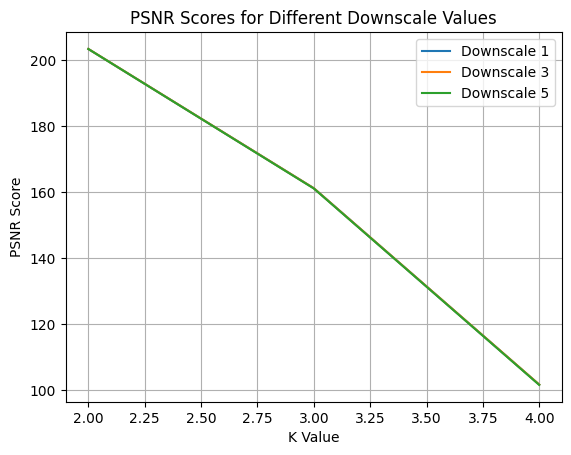

In [ ]:
import matplotlib.pyplot as plt
downscale = [1,3,5]
K = [2,3,4]
mean_psnr_scores1 = [np.mean(psnr_list) for k, psnr_list in psnr_scores1.items()]
mean_psnr_scores2 = [np.mean(psnr_list) for k, psnr_list in psnr_scores2.items()]
mean_psnr_scores3 = [np.mean(psnr_list) for k, psnr_list in psnr_scores3.items()]
plt.plot(K, mean_psnr_scores1, label='Downscale 1')
plt.plot(K, mean_psnr_scores2, label='Downscale 3')
plt.plot(K, mean_psnr_scores3, label='Downscale 5')

# Add labels and legend
plt.xlabel('K Value')
plt.ylabel('PSNR Score')
plt.title('PSNR Scores for Different Downscale Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

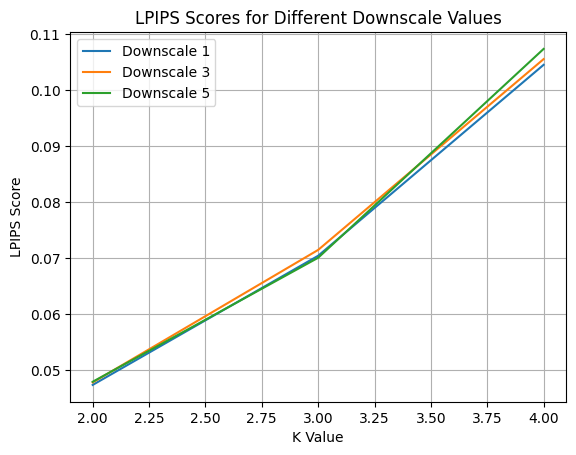

In [ ]:
import matplotlib.pyplot as plt
K = [2,3,4]
mean_lpips_scores1 = [np.mean(lpips_list) for k, lpips_list in lpips_scores1.items()]
mean_lpips_scores2 = [np.mean(lpips_list) for k, lpips_list in lpips_scores2.items()]
mean_lpips_scores3 = [np.mean(lpips_list) for k, lpips_list in lpips_scores3.items()]

plt.plot(K, mean_lpips_scores1, label='Downscale 1')
plt.plot(K, mean_lpips_scores2, label='Downscale 3')
plt.plot(K, mean_lpips_scores3, label='Downscale 5')

# Add labels and legend
plt.xlabel('K Value')
plt.ylabel('LPIPS Score')
plt.title('LPIPS Scores for Different Downscale Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [33]:
K = 2
downscale = 1
# Directory containing the image frames
s = "K:" + str(K) + "_downscale:" + str(downscale)
frames_folder = os.path.join('/content/drive/MyDrive/DVPA_A1/00001',s)

s = "Video_K:" + str(K) + "_downscale:" + str(downscale)
output_folder = os.path.join('/content/drive/MyDrive/DVPA_A1/00001',s)
output_video_file = os.path.join(output_folder, s)  # Specify the full path
output_video_file = os.path.join(output_folder, 'output_video.mp4')

frame_rate = 5
frame_size = (1920, 1080)
image_files = sorted([os.path.join(frames_folder, f) for f in os.listdir(frames_folder) if f.endswith('.png')])
image_files.sort()

output_video = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_file, fourcc, frame_rate,(1024, 576))

for image_file in image_files:
    frame = cv2.imread(image_file)
    out.write(frame)

out.release()

print(f"Video '{output_video_file}' created successfully.")

Video '/content/drive/MyDrive/DVPA_A1/00001/Video_K:2_downscale:1/Video_K:2_downscale:1' created successfully.


In [ ]:
downscale = 1
source_folder1 = '/content/drive/MyDrive/DVPA_A1/00006/rgb'
rgb_images_path_list = sorted([os.path.join(source_folder1, f) for f in os.listdir(source_folder1) if f.endswith('.png')])
output_path1 = '/content/drive/MyDrive/DVPA_A1/00006'
# K = 2
save_interpolated_frames(rgb_images_path_list,output_path1,2,downscale)
# K = 3
save_interpolated_frames(rgb_images_path_list,output_path1,3,downscale)
# K = 4
save_interpolated_frames(rgb_images_path_list,output_path1,4,downscale)

In [17]:
downscale = 1
psnr_scores1 = {}
lpips_scores1 = {}
lpips_model = lpips.LPIPS(net='alex')
for K in range(2, 5):  # Adjust the range as needed
  i = 0
  s = "K:" + str(K) + "_downscale:" + str(downscale)
  folder1 = '/content/drive/MyDrive/DVPA_A1/00006/rgb'
  folder2 = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)
  for root, _, files in os.walk(folder1):
    for filename in files:
      i = i+1
      if(i%K == 0):
        continue
      # Check if the corresponding image exists in folder2
      image_path1 = os.path.join(root, filename)
      image_path2 = os.path.join(folder2, filename)  # Adjust the file extension as needed
      if os.path.exists(image_path2):
        psnr, lpips_score = calculate_metrics(image_path1, image_path2,lpips_model)
        if K not in psnr_scores1:
          psnr_scores1[K] = []
          lpips_scores1[K] = []

        psnr_scores1[K].append(psnr)
        lpips_scores1[K].append(lpips_score)

# Compute average PSNR and LPIPS scores for each scale and K
for K, psnr_list in psnr_scores1.items():
  avg_psnr = np.mean(psnr_list)
  avg_lpips = np.mean(lpips_scores1[K])
  print(f'For K={K}, with number of scales={downscale}, Average PSNR: {avg_psnr:.2f}, Average LPIPS: {avg_lpips:.4f}')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
For K=2, with number of scales=1, Average PSNR: 227.46, Average LPIPS: 0.0601
For K=3, with number of scales=1, Average PSNR: 154.25, Average LPIPS: 0.1068
For K=4, with number of scales=1, Average PSNR: 131.08, Average LPIPS: 0.1431


In [ ]:
downscale = 3
source_folder1 = '/content/drive/MyDrive/DVPA_A1/00006/rgb'
rgb_images_path_list = sorted([os.path.join(source_folder1, f) for f in os.listdir(source_folder1) if f.endswith('.png')])
output_path1 = '/content/drive/MyDrive/DVPA_A1/00006'
# K = 2
save_interpolated_frames(rgb_images_path_list,output_path1,2,downscale)
# K = 3
save_interpolated_frames(rgb_images_path_list,output_path1,3,downscale)
# K = 4
save_interpolated_frames(rgb_images_path_list,output_path1,4,downscale)

In [18]:
downscale = 3
psnr_scores2 = {}
lpips_scores2 = {}
lpips_model = lpips.LPIPS(net='alex')
for K in range(2, 5):  # Adjust the range as needed
  i = 0
  s = "K:" + str(K) + "_downscale:" + str(downscale)
  folder1 = '/content/drive/MyDrive/DVPA_A1/00006/rgb'
  folder2 = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)
  for root, _, files in os.walk(folder1):
    for filename in files:
      i = i+1
      if(i%K == 0):
        continue
      # Check if the corresponding image exists in folder2
      image_path1 = os.path.join(root, filename)
      image_path2 = os.path.join(folder2, filename)  # Adjust the file extension as needed
      if os.path.exists(image_path2):
        psnr, lpips_score = calculate_metrics(image_path1, image_path2,lpips_model)
        if K not in psnr_scores2:
          psnr_scores2[K] = []
          lpips_scores2[K] = []

        psnr_scores2[K].append(psnr)
        lpips_scores2[K].append(lpips_score)

# Compute average PSNR and LPIPS scores for each scale and K
for K, psnr_list in psnr_scores2.items():
  avg_psnr = np.mean(psnr_list)
  avg_lpips = np.mean(lpips_scores2[K])
  print(f'For K={K}, with number of scales={downscale}, Average PSNR: {avg_psnr:.2f}, Average LPIPS: {avg_lpips:.4f}')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
For K=2, with number of scales=3, Average PSNR: 227.50, Average LPIPS: 0.0634
For K=3, with number of scales=3, Average PSNR: 154.27, Average LPIPS: 0.1126
For K=4, with number of scales=3, Average PSNR: 131.13, Average LPIPS: 0.1513


In [ ]:
downscale = 5
source_folder1 = '/content/drive/MyDrive/DVPA_A1/00006/rgb'
rgb_images_path_list = sorted([os.path.join(source_folder1, f) for f in os.listdir(source_folder1) if f.endswith('.png')])
output_path1 = '/content/drive/MyDrive/DVPA_A1/00006'
# K = 2
save_interpolated_frames(rgb_images_path_list,output_path1,2,downscale)
# K = 3
save_interpolated_frames(rgb_images_path_list,output_path1,3,downscale)
# K = 4
save_interpolated_frames(rgb_images_path_list,output_path1,4,downscale)

In [19]:
downscale = 5
psnr_scores3 = {}
lpips_scores3 = {}

lpips_model = lpips.LPIPS(net='alex')
for K in range(2, 5):  # Adjust the range as needed
  i = 0
  s = "K:" + str(K) + "_downscale:" + str(downscale)
  folder1 = '/content/drive/MyDrive/DVPA_A1/00006/rgb'
  folder2 = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)
  for root, _, files in os.walk(folder1):
    for filename in files:
      i = i+1
      if(i%K == 0):
        continue
      # Check if the corresponding image exists in folder2
      image_path1 = os.path.join(root, filename)
      image_path2 = os.path.join(folder2, filename)  # Adjust the file extension as needed
      if os.path.exists(image_path2):
        psnr, lpips_score = calculate_metrics(image_path1, image_path2,lpips_model)
        if K not in psnr_scores3:
          psnr_scores3[K] = []
          lpips_scores3[K] = []

        psnr_scores3[K].append(psnr)
        lpips_scores3[K].append(lpips_score)

# Compute average PSNR and LPIPS scores for each scale and K
for K, psnr_list in psnr_scores3.items():
  avg_psnr = np.mean(psnr_list)
  avg_lpips = np.mean(lpips_scores3[K])
  print(f'For K={K}, with number of scales={downscale}, Average PSNR: {avg_psnr:.2f}, Average LPIPS: {avg_lpips:.4f}')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/alex.pth
For K=2, with number of scales=5, Average PSNR: 227.50, Average LPIPS: 0.0656
For K=3, with number of scales=5, Average PSNR: 154.27, Average LPIPS: 0.1160
For K=4, with number of scales=5, Average PSNR: 131.10, Average LPIPS: 0.1549


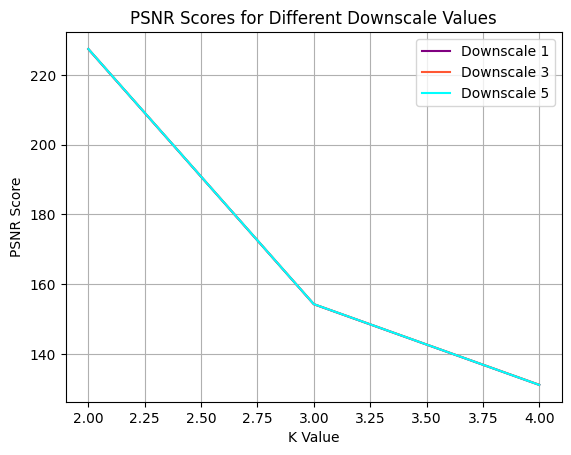

In [24]:
import matplotlib.pyplot as plt
import numpy as np

downscale = [1, 3, 5]
K = [2, 3, 4]
mean_psnr_scores1 = [np.mean(psnr_list) for k, psnr_list in psnr_scores1.items()]
mean_psnr_scores2 = [np.mean(psnr_list) for k, psnr_list in psnr_scores2.items()]
mean_psnr_scores3 = [np.mean(psnr_list) for k, psnr_list in psnr_scores3.items()]

# Specify custom colors
color1 = 'purple'
color2 = '#FF5733'  # Hexadecimal color code
color3 = 'cyan'

plt.plot(K, mean_psnr_scores1, label='Downscale 1', color=color1)
plt.plot(K, mean_psnr_scores2, label='Downscale 3', color=color2)
plt.plot(K, mean_psnr_scores3, label='Downscale 5', color=color3)

# Add labels and legend
plt.xlabel('K Value')
plt.ylabel('PSNR Score')
plt.title('PSNR Scores for Different Downscale Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


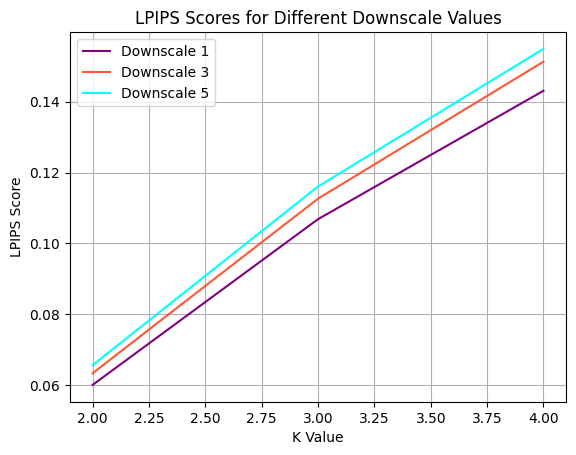

In [25]:
import matplotlib.pyplot as plt
import numpy as np

K = [2, 3, 4]
mean_lpips_scores1 = [np.mean(lpips_list) for k, lpips_list in lpips_scores1.items()]
mean_lpips_scores2 = [np.mean(lpips_list) for k, lpips_list in lpips_scores2.items()]
mean_lpips_scores3 = [np.mean(lpips_list) for k, lpips_list in lpips_scores3.items()]

# Specify custom colors
color1 = 'purple'
color2 = '#FF5733'  # Hexadecimal color code
color3 = 'cyan'

plt.plot(K, mean_lpips_scores1, label='Downscale 1', color=color1)
plt.plot(K, mean_lpips_scores2, label='Downscale 3', color=color2)
plt.plot(K, mean_lpips_scores3, label='Downscale 5', color=color3)

# Add labels and legend
plt.xlabel('K Value')
plt.ylabel('LPIPS Score')
plt.title('LPIPS Scores for Different Downscale Values')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [29]:
K = 2
downscale = 1
# Directory containing the image frames
s = "K:" + str(K) + "_downscale:" + str(downscale)
frames_folder = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)

s = "Video_K:" + str(K) + "_downscale:" + str(downscale)
output_folder = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)
output_video_file = os.path.join(output_folder, 'output_video.mp4')  # Specify the full path

frame_rate = 5
frame_size = (1920, 1080)
image_files = sorted([os.path.join(frames_folder, f) for f in os.listdir(frames_folder) if f.endswith('.png')])
image_files.sort()

output_video = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_file, fourcc, frame_rate,(1024, 576))

for image_file in image_files:
    frame = cv2.imread(image_file)
    out.write(frame)

out.release()

print(f"Video '{output_video_file}' created successfully.")

Video '/content/drive/MyDrive/DVPA_A1/00006/Video_K:2_downscale:1/output_video.mp4' created successfully.


In [31]:
K = 4
downscale = 1
# Directory containing the image frames
s = "K:" + str(K) + "_downscale:" + str(downscale)
frames_folder = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)

s = "Video_K:" + str(K) + "_downscale:" + str(downscale)
output_folder = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)
output_video_file = os.path.join(output_folder, 'output_video.mp4')  # Specify the full path

frame_rate = 5
frame_size = (1920, 1080)
image_files = sorted([os.path.join(frames_folder, f) for f in os.listdir(frames_folder) if f.endswith('.png')])
image_files.sort()

output_video = 'output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_file, fourcc, frame_rate,(1024, 576))

for image_file in image_files:
    frame = cv2.imread(image_file)
    out.write(frame)

out.release()

print(f"Video '{output_video_file}' created successfully.")

Video '/content/drive/MyDrive/DVPA_A1/00006/Video_K:4_downscale:1/output_video.mp4' created successfully.


In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
K = 4
downscale = 1
# Directory containing the image frames
s = "K:" + str(K) + "_downscale:" + str(downscale)
frames_folder = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)

s = "Video_K:" + str(K) + "_downscale:" + str(downscale)
output_folder = os.path.join('/content/drive/MyDrive/DVPA_A1/00006',s)
if not os.path.exists(output_folder):
  os.makedirs(output_folder)
output_video_file = os.path.join(output_folder, 'output_video.mp4')

frame_rate = 5
frame_size = (1920, 1080)
image_files = sorted([os.path.join(frames_folder, f) for f in os.listdir(frames_folder) if f.endswith('.png')])
image_files.sort()

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_file, fourcc, frame_rate, frame_size)

for image_file in image_files:
    frame = cv2.imread(image_file)
    out.write(frame)
out.release()

print(f"Video '{output_video_file}' created successfully.")
